# Reinforcement Learning for trading

To train a trading agent, we need to create a market environment that provides price and other information, offers trading-related actions, and keeps track of the portfolio to reward the agent accordingly.

## How to Design an OpenAI trading environment

The OpenAI Gym allows for the design, registration, and utilization of environments that adhere to its architecture, as described in its [documentation](https://github.com/openai/gym/tree/master/gym/envs#how-to-create-new-environments-for-gym). The [trading_env.py](trading_env.py) file implements an example that illustrates how to create a class that implements the requisite `step()` and `reset()` methods.

The trading environment consists of three classes that interact to facilitate the agent's activities:
 1. The `DataSource` class loads a time series, generates a few features, and provides the latest observation to the agent at each time step. 
 2. `TradingSimulator` tracks the positions, trades and cost, and the performance. It also implements and records the results of a buy-and-hold benchmark strategy. 
 3. `TradingEnvironment` itself orchestrates the process. 

## A basic trading game

To train the agent, we need to set up a simple game with a limited set of options, a relatively low-dimensional state, and other parameters that can be easily modified and extended.

More specifically, the environment samples a stock price time series for a single ticker using a random start date to simulate a trading period that, by default, contains 252 days, or 1 year. The state contains the (scaled) price and volume, as well as some technical indicators like the percentile ranks of price and volume, a relative strength index (RSI), as well as 5- and 21-day returns. The agent can choose from three actions:

- **Buy**: Invest capital for a long position in the stock
- **Flat**: Hold cash only
- **Sell short**: Take a short position equal to the amount of capital

The environment accounts for trading cost, which is set to 10bps by default. It also deducts a 1bps time cost per period. It tracks the net asset value (NAV) of the agent's portfolio and compares it against the market portfolio (which trades frictionless to raise the bar for the agent).

We use the same DDQN agent and neural network architecture that successfully learned to navigate the Lunar Lander environment. We let exploration continue for 500,000 time steps (~2,000 1yr trading periods) with linear decay of ε to 0.1 and exponential decay at a factor of 0.9999 thereafter.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
from time import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf

import gym
from gym.envs.registration import register

In [3]:
from DDQNAgent import DDQNAgent

In [4]:
sns.set_style('whitegrid')

### Helper functions

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:05.2f}'.format(m, s)

## Set up Gym Environment

Before using the custom environment, just like we used the Lunar Lander environment, we need to register it:

In [6]:
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=1000
)

### Initialize Trading Environment

We can instantiate the environment by using the desired trading costs and ticker:

In [7]:
trading_environment = gym.make('trading-v0')
trading_environment.env.trading_cost_bps = 1e-3
trading_environment.env.time_cost_bps = 1e-4
trading_environment.env.ticker = 'AAPL'
trading_environment.seed(42)

INFO:trading_env:trading_env logger started.
INFO:trading_env:loading data for AAPL...
INFO:trading_env:got data for AAPL...
INFO:trading_env:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8596 entries, (Timestamp('1981-05-06 00:00:00'), 'AAPL') to (Timestamp('2018-03-27 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   close           8596 non-null   float64
 1   volume          8596 non-null   float64
 2   returns         8596 non-null   float64
 3   close_pct_100   8596 non-null   float64
 4   volume_pct_100  8596 non-null   float64
 5   close_pct_20    8596 non-null   float64
 6   volume_pct_20   8596 non-null   float64
 7   return_5        8596 non-null   float64
 8   return_21       8596 non-null   float64
 9   rsi             8596 non-null   float64
dtypes: float64(10)
memory usage: 841.8+ KB


[42]

### Get Environment Params

In [8]:
state_dim = trading_environment.observation_space.shape[0]  
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

## Define hyperparameters

In [9]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

### NN Architecture

In [10]:
architecture = (256, ) * 3  # units per layer
learning_rate = 5e-5  # learning rate
l2_reg = 1e-6  # L2 regularization

### Experience Replay

In [11]:
replay_capacity = int(1e6)
batch_size = 16

### $\epsilon$-greedy Policy

In [12]:
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 1e5

## Create DDQN Agent

We will use [TensorFlow](https://www.tensorflow.org/) to create our Double Deep Q-Network .

In [13]:
tf.keras.backend.clear_session()

In [14]:
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

## Run Experiment

### Set parameters

In [15]:
total_steps = 0
max_episodes = 10000

### Initialize variables

In [16]:
episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

## Visualiztion

In [17]:
def track_results(episode, episode_nav,
                  market_nav, ratio,
                  total,
                  epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | NAV: {:>5.3f} | Market NAV: {:>5.3f} | Delta: {:4.0f} | {} | eps: {:>6.3f}'
    print(template.format(episode, episode_nav, market_nav, ratio, format_time(total), epsilon))

### Train Agent

In [18]:
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
        ddqn.memorize_transition(this_state, action, reward, next_state,
                                 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    result = trading_environment.env.sim.result()
    final = result.iloc[-1]

    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    market_nav = final.market_nav
    market_navs.append(market_nav)

    diff = nav - market_nav
    diffs.append(diff)
    if episode % 50 == 0:
        track_results(episode, np.mean(navs[-100:]),
                      np.mean(market_navs[-100:]),
                      np.sum([s > 0 for s in diffs[-100:]]), 
                      ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break        

trading_environment.close()

  50 | NAV: 0.878 | Market NAV: 1.298 | Delta:   13 | 00:00.00 | eps:  0.880
 100 | NAV: 0.848 | Market NAV: 1.351 | Delta:   22 | 00:00.00 | eps:  0.761
 150 | NAV: 0.790 | Market NAV: 1.349 | Delta:   19 | 00:00.00 | eps:  0.641
 200 | NAV: 0.755 | Market NAV: 1.311 | Delta:   15 | 00:00.00 | eps:  0.521
 250 | NAV: 0.755 | Market NAV: 1.350 | Delta:   15 | 00:00.00 | eps:  0.402
 300 | NAV: 0.786 | Market NAV: 1.304 | Delta:   25 | 00:00.00 | eps:  0.282
 350 | NAV: 0.809 | Market NAV: 1.278 | Delta:   25 | 00:00.00 | eps:  0.162
 400 | NAV: 0.781 | Market NAV: 1.303 | Delta:   15 | 00:00.00 | eps:  0.050
 450 | NAV: 0.832 | Market NAV: 1.324 | Delta:   14 | 00:00.00 | eps:  0.050
 500 | NAV: 0.876 | Market NAV: 1.324 | Delta:   17 | 00:00.00 | eps:  0.050
 550 | NAV: 0.846 | Market NAV: 1.323 | Delta:   16 | 00:00.00 | eps:  0.050
 600 | NAV: 0.841 | Market NAV: 1.327 | Delta:   21 | 00:00.00 | eps:  0.050
 650 | NAV: 0.853 | Market NAV: 1.323 | Delta:   27 | 00:00.00 | eps:  0.050

5400 | NAV: 1.295 | Market NAV: 1.364 | Delta:   36 | 00:00.00 | eps:  0.050
5450 | NAV: 1.335 | Market NAV: 1.372 | Delta:   36 | 00:00.00 | eps:  0.050
5500 | NAV: 1.385 | Market NAV: 1.531 | Delta:   38 | 00:00.00 | eps:  0.050
5550 | NAV: 1.377 | Market NAV: 1.480 | Delta:   38 | 00:00.00 | eps:  0.050
5600 | NAV: 1.292 | Market NAV: 1.346 | Delta:   36 | 00:00.00 | eps:  0.050
5650 | NAV: 1.312 | Market NAV: 1.373 | Delta:   36 | 00:00.00 | eps:  0.050
5700 | NAV: 1.213 | Market NAV: 1.300 | Delta:   36 | 00:00.00 | eps:  0.050
5750 | NAV: 1.181 | Market NAV: 1.304 | Delta:   34 | 00:00.00 | eps:  0.050
5800 | NAV: 1.327 | Market NAV: 1.314 | Delta:   38 | 00:00.00 | eps:  0.050
5850 | NAV: 1.288 | Market NAV: 1.261 | Delta:   42 | 00:00.00 | eps:  0.050
5900 | NAV: 1.165 | Market NAV: 1.370 | Delta:   35 | 00:00.00 | eps:  0.050
5950 | NAV: 1.230 | Market NAV: 1.375 | Delta:   38 | 00:00.00 | eps:  0.050
6000 | NAV: 1.222 | Market NAV: 1.274 | Delta:   44 | 00:00.00 | eps:  0.050

### Store Results

In [21]:
results = pd.DataFrame({'episode': list(range(1, episode + 1)),
                        'nav': navs,
                        'market_nav': market_navs,
                        'outperform': diffs})

fn = 'trading_agent_result_no_cost.csv'
results.to_csv(fn, index=False)

### Evaluate Results

In [22]:
results = pd.read_csv('trading_agent_result_no_cost.csv')
results.columns = ['Episode', 'Agent', 'Market', 'difference']
results = results.set_index('Episode')
results['Strategy Wins (%)'] = (results.difference > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              10000 non-null  float64
 1   Market             10000 non-null  float64
 2   difference         10000 non-null  float64
 3   Strategy Wins (%)  9901 non-null   float64
dtypes: float64(4)
memory usage: 390.6 KB


The following diagram shows the rolling average of agent and market returns over 100 periods on the left, and the share of the last 100 periods the agent outperformed the market on the right. It uses AAPL stock data for which there are some 9,000 daily price and volume observations. Training stopped after 14,000 trading periods when the agent beat the market 10 consecutive times.

It shows how the agent's performance improves significantly while exploring at a higher rate over the first ~3,000 periods (that is, years) and approaches a level where it outperforms the market around 40 percent of the time, despite transaction costs. In a few instances, it beats the market about half the time out of 100 periods:

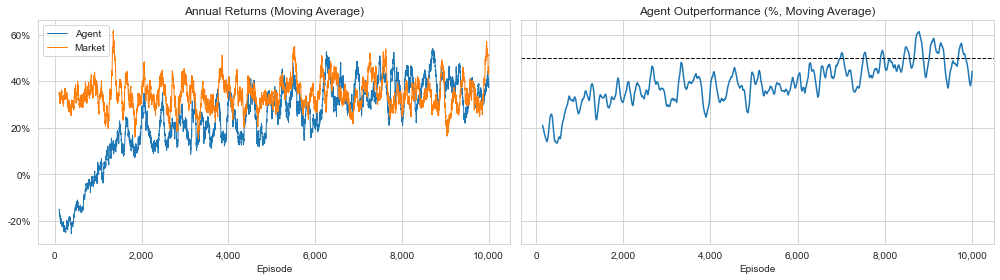

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4), sharey=True)
(results[['Agent', 'Market']]
 .sub(1)
 .rolling(100)
 .mean()
 .plot(ax=axes[0], 
       title='Annual Returns (Moving Average)', lw=1))
results['Strategy Wins (%)'].div(100).rolling(50).mean().plot(ax=axes[1], title='Agent Outperformance (%, Moving Average)');
for ax in axes:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)
fig.tight_layout()
fig.savefig('figures/trading_agent', dpi=300)

## Summary

This relatively simple agent uses limited information beyond the latest market data and the reward signal compared to the machine learning models we covered elsewhere in this book. Nonetheless, it learns to make a profit and approach the market (after training on several thousand year's worth of data, which takes around 30 minutes).

Keep in mind that using a single stock also increase the risk of overfitting the data by a lot. You can test your trained agent on new data using the saved model (see the notebook on the Lunar Lander).

In conclusion, we have demonstrated the mechanics of setting up a RL trading environment and experimented with a basic agent that uses a small number of technical indicators. You should try to extend both the environment and the agent so that you can choose from several assets, size their positions, and manage risks.

More specifically, the environment samples a stock price time series for a single ticker from a random start date to simulate a trading period of 252 days, or 1 year (default). The agent has three options, that is, buying (long), short, or exiting its position, and faces a 10bps trading plus a 1bps time cost per period.